In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas.plotting import parallel_coordinates
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tick

In [2]:
#sns.set_context("paper")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)

sns.set(font='serif')
sns.set_style("ticks")

In [65]:
# Load and prepare data

basic = pd.read_csv("data/rerun/output/articles_metadata.csv", index_col="pmid")
funding = pd.read_csv("data/rerun/output/articles_funding_dummies.csv", index_col="pmid")
mesh = pd.read_csv("data/rerun/output/articles_mesh_term_dummies.csv", index_col="pmid")
mesh_subterm = pd.read_csv("data/rerun/output/articles_mesh_subterm_dummies.csv", index_col="pmid")
news = pd.read_csv("data/rerun/output/articles_news_coverage.csv", index_col="pmid")

# Convert to binary columns to bool
funding = funding.apply(lambda x: x==1)
mesh = mesh.apply(lambda x: x==1)
mesh_subterm = mesh_subterm.apply(lambda x: x==1)
news[['news_mention', 'tier1','tier2','tier3','tier4']] = news[['news_mention', 'tier1','tier2','tier3','tier4']].apply(lambda x: x==1)

# Several views of the dataset
us_funding = funding.us_gov_funding == 1
news_mentions = news.news_count > 0
most_f_cancers = mesh[us_funding].sum().sort_values(ascending=False)
mapping = {cancer: i for i, cancer in enumerate(most_f_cancers.keys())}

labels = {'Breast Neoplasms':'Breast',
          'Lung Neoplasms':'Lung',
          'Prostatic Neoplasms':'Prostatic',
          'Leukemia':'Leukemia',
          'Colorectal Neoplasms':'Colon',
          'Pancreatic Neoplasms':'Pancreatic',
          'Melanoma':'Melanoma',
          'Liver Neoplasms':'Liver',
          'Lymphoma, Non-Hodgkin':'Lymphoma, NH*',
          'Kidney Neoplasms':'Kidney',
          'Endometrial Neoplasms':'Endometrial',
          'Thyroid Neoplasms':'Thyroid',
          'Urinary Bladder Neoplasms':'Urinary/Bladder'}

In [64]:
def shorten_cancers(cols):
    return [labels[x] for x in cols]

def update_mentions(row):
    for col in mesh.columns:
        if row[col]:
            row[col] = row['news_count']
        else:
            row[col] = None
    return row

## Boxplot of mentions

In [70]:
df = news[['news_count']].merge(mesh, left_index=True, right_index=True)
df = df[us_funding]
df = df.apply(update_mentions, axis=1)[most_f_cancers.keys()]
df = df.replace(0, np.nan)

df.columns = shorten_cancers(df.columns)

pdf1 = df.melt(value_name="mentions", var_name="cancer").dropna()

# Remove outliers beyond Q3+1.5*IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

y_max = max(Q3 + 1.5 * IQR)

pdf1 = pdf1[pdf1.mentions <= y_max]

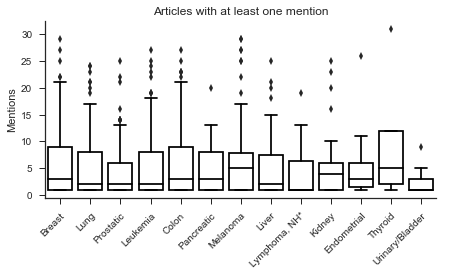

In [91]:
title = "Articles with at least one mention"
ylabel = "Mentions"

figsize = (6.4, 4)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x="cancer", y="mentions", data=pdf1, palette=cp, ax=ax)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels
ax.set_title(title)
ax.xaxis.label.set_visible(False)
ax.set_ylabel(ylabel)

# Savefig
plt.tight_layout()
fig.savefig("plots/fig3.png", dpi=300)

## Plot - Rank Parallel Coordinates

How do the different cancers' ranks compare across:

- number of funded articles
- estimated new cases
- estimated deaths
- estimated funding

Set `add_news_mentions = True` to add the ranks by average news mentions

In [76]:
# Data available in the respective tables in the paper
est_new = [255190, 222500, 135430, 62130, 161360, 53670, 40710, 87110, 72240, 63990, 61380, 56870, 79030]
est_death = [41070, 155870, 50260, 24500, 26730, 43090, 28920, 9730, 20140, 14400, 10920, 2010, 16870]
est_fund = [543.7,256.2,209.3,246.9,228.9,125.3,70.3,132.8,122.4,None,None,None,None]

df = mesh[us_funding]
pdf2 = pd.DataFrame({'Articles':most_f_cancers.tolist(),
                     'New cases': est_new,
                     'Deaths': est_death,
                     'Mentions': total_mentions.tolist()}, index=most_f_cancers.keys())

plotcols = ['New cases', 'Deaths', 'Articles', 'Mentions']
ranks = pdf2[plotcols].rank(ascending=False).reset_index()
loc = tick.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals

title = "Cancer ranks"

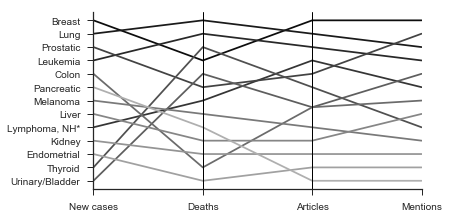

In [92]:
cp = sns.color_palette("binary", 18)
cm = ListedColormap(cp[::-1][:13])

figsize = (6.4, 3.2)
fig, ax = plt.subplots(figsize=figsize)
parallel_coordinates(ranks, 'index', colormap=cm, ax=ax)

plt.yticks(range(1,14))

ax.invert_yaxis()
def mjrFormatter(x, pos):
    return "{}".format(labels[most_f_cancers.keys().tolist()[pos]])
ax.yaxis.set_major_formatter(tick.FuncFormatter(mjrFormatter))
ax.legend_.remove()
    
# Hide the right and top spines
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set labels
# ax.set_title(title)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# Savefig
plt.tight_layout()
fig.savefig("plots/fig1.png", dpi=300)

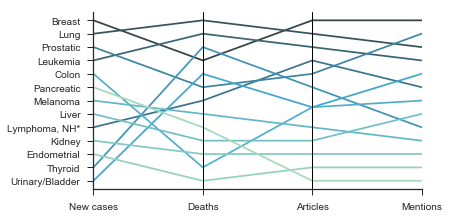

In [105]:
cp = sns.color_palette("GnBu_d", 13)
cm = ListedColormap(cp)

figsize = (6.4, 3.2)
fig, ax = plt.subplots(figsize=figsize)
parallel_coordinates(ranks, 'index', colormap=cm, ax=ax)

plt.yticks(range(1,14))

ax.invert_yaxis()
def mjrFormatter(x, pos):
    return "{}".format(labels[most_f_cancers.keys().tolist()[pos]])
ax.yaxis.set_major_formatter(tick.FuncFormatter(mjrFormatter))
ax.legend_.remove()
    
# Hide the right and top spines
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set labels
# ax.set_title(title)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# Savefig
plt.tight_layout()
fig.savefig("plots/fig1_col.png", dpi=300)

# Plot - Stacked bar plot of stages of cancer

In [85]:
bar_order = shorten_cancers(most_f_cancers.keys())
label_order = ['prevention & control', 'diagnosis', 'therapy']

columns = [['prevention & control', 'diagnosis', 'therapy'],
        ['prevention & control', 'diagnosis'],
        ['prevention & control']]

colors = ['w', 'grey', 'black']

titles = ["All articles", "Articles with at least one mention"]
tx = 5
tys = [300, 60]

panels = ["A", "B"]
px = -2
pys = [355, 85]

df = mesh.copy()
df.columns = shorten_cancers(df.columns)
df = df.merge(mesh_subterm, left_index=True, right_index=True)
df = df[us_funding]

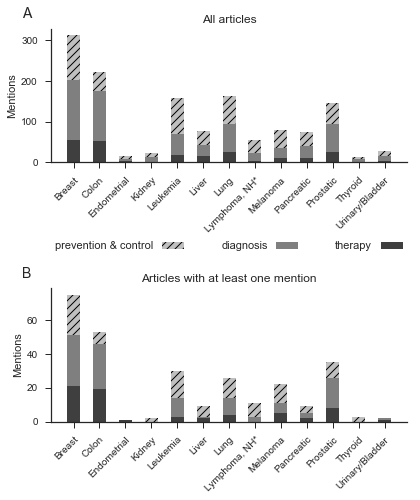

In [94]:
cp = sns.color_palette("binary", 3)

fig, axes = plt.subplots(2, 1, figsize=(6,7))
for i, ax in enumerate(axes):
    pdf = df    
    if i == 1:
        pdf = pdf[news_mentions.reindex(df.index)]

    pdf = pdf.melt(id_vars=mesh_subterm.columns, var_name="cancer_type")
    pdf = pdf[pdf.value]
    pdf = pdf.groupby(["cancer_type"])[['prevention & control', 'diagnosis', 'therapy']].sum()
    
    pdf = pdf.loc[[labels[x] for x in most_f_cancers.keys().tolist()]]
    
    for column, col, l in zip(columns, cp, label_order):
        pattern = None
        if len(column) == 3:
            pattern = "///"
        bars = ax.bar(x=bar_order,
                      height=pdf[column].sum(axis=1),
                      width=.5,
                      color=col, hatch=pattern,
                      label=l)
    
    ax.set_title(titles[i])
    #ax.text(tx, tys[i], titles[i], {'fontsize':'13'})
    ax.text(px, pys[i], panels[i], {'fontsize':'14'})
    
    # Hide the right and top spines
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("Mentions")
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
lgd = axes[0].legend(
    bbox_to_anchor=(0., -0.7, 1., .102), loc=8,
    ncol=3, mode="expand", borderaxespad=0.,
    fontsize=11,  markerfirst=False)

plt.tight_layout(h_pad=3.4)

# Savefig
fig.savefig("plots/fig2.png", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

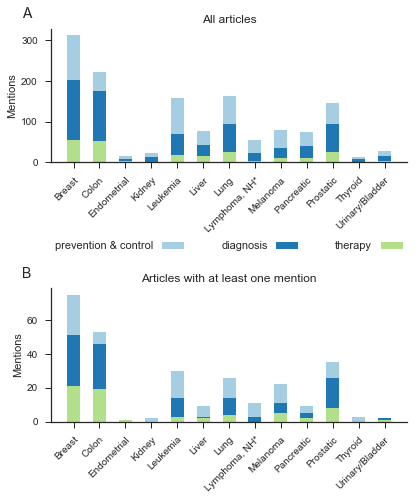

In [103]:
cp = sns.color_palette("Paired", 3)

fig, axes = plt.subplots(2, 1, figsize=(6,7))
for i, ax in enumerate(axes):
    pdf = df    
    if i == 1:
        pdf = pdf[news_mentions.reindex(df.index)]

    pdf = pdf.melt(id_vars=mesh_subterm.columns, var_name="cancer_type")
    pdf = pdf[pdf.value]
    pdf = pdf.groupby(["cancer_type"])[['prevention & control', 'diagnosis', 'therapy']].sum()
    
    pdf = pdf.loc[[labels[x] for x in most_f_cancers.keys().tolist()]]
    
    for column, col, l in zip(columns, cp, label_order):
        bars = ax.bar(x=bar_order,
                      height=pdf[column].sum(axis=1),
                      width=.5,
                      color=col,
                      label=l)
    
    ax.set_title(titles[i])
    #ax.text(tx, tys[i], titles[i], {'fontsize':'13'})
    ax.text(px, pys[i], panels[i], {'fontsize':'14'})
    
    # Hide the right and top spines
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("Mentions")
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
lgd = axes[0].legend(
    bbox_to_anchor=(0., -0.7, 1., .102), loc=8,
    ncol=3, mode="expand", borderaxespad=0.,
    fontsize=11,  markerfirst=False)

plt.tight_layout(h_pad=3.4)

# Savefig
fig.savefig("plots/fig2_col.png", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')